In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#Set your project path 
import os
project_path =  '/content/drive/My Drive/Colab Notebooks/Capstone/Data'
os.chdir(project_path)
path = '.'

In [10]:
ls

'GCP Credits Request Link - RSNA.txt'     stage_2_test_images/
 rsna-pneumonia-detection-challenge.zip   stage_2_train_images/
 stage_2_detailed_class_info.csv          stage_2_train_labels.csv
 stage_2_sample_submission.csv


In [0]:
data_path = "rsna-pneumonia-detection-challenge.zip"
from zipfile import ZipFile
with ZipFile(data_path, 'r') as zip:
  zip.extractall()

In [0]:
!ls

'GCP Credits Request Link - RSNA.txt'	  stage_2_test_images
 rsna-pneumonia-detection-challenge.zip   stage_2_train_images
 stage_2_detailed_class_info.csv	  stage_2_train_labels.csv
 stage_2_sample_submission.csv


In [6]:
!pip install pydicom

     |████████████████████████████████| 35.5MB 1.8MB/s 


In [0]:
import pydicom
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
import pylab
from tabulate import tabulate
from matplotlib.patches import Rectangle
from scipy import stats
from IPython.display import Image

Load data from path, each CSV into df labels_pd and detailed_pd respectively
and print df

In [11]:
#path to the trained images dataset 
DATADIR = '/content/drive/My Drive/Colab Notebooks/Capstone/Data/stage_2_train_images/'
labels_pd = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Capstone/Data/stage_2_train_labels.csv')
detailed_pd = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Capstone/Data/stage_2_detailed_class_info.csv')
Patients_ID = os.listdir(DATADIR) 
print(labels_pd.head())
print(detailed_pd.head())

                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

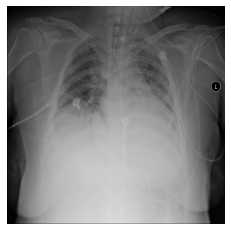

In [12]:
IDNumber = 5
patientId = labels_pd['patientId'][IDNumber]
dcm = DATADIR + '%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm)
print(dcm_data)
im = dcm_data.pixel_array
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')
isPneumonia = labels_pd['Target'][IDNumber]
if isPneumonia == 1:
  print("Patient has Pneumonia")
elif isPneumonia == 0:
  print("Patient does not have Pneumonia")

In [0]:
PatientInfoDf = pd.DataFrame(columns = ['ID','Modality','Sex','Age','BodyPart','View','X_coordinate','Y_coordinate','width','height','PneumoniaClass','Target','dcmPath'])
for x in range(len(labels_pd)):
  patientId = labels_pd['patientId'][x]
  dcmPath = DATADIR + '%s.dcm' % patientId
  dcm_data = pydicom.read_file(dcmPath)
  Modality = dcm_data.Modality
  Sex = dcm_data.PatientSex
  Age = dcm_data.PatientAge
  BodyPart = dcm_data.BodyPartExamined
  View = dcm_data.ViewPosition
  X_coordinate = labels_pd['x'][x]
  Y_coordinate = labels_pd['y'][x]
  width = labels_pd['width'][x]
  height = labels_pd['height'][x]
  PneumoniaClass = detailed_pd['class'][x]
  Target = labels_pd['Target'][x]
  PatientInfoDf = PatientInfoDf.append({'ID': patientId,'Modality': Modality,'Sex': Sex,'Age': Age,'BodyPart': BodyPart,'View': View,'X_coordinate': X_coordinate,'Y_coordinate': Y_coordinate,'width': width,'height': height,'PneumoniaClass': PneumoniaClass,'Target': Target,'dcmPath': dcmPath}, ignore_index=True)

In [0]:
PatientInfoDfTemp = PatientInfoDf

In [15]:
PatientInfoDfTemp.shape

(30227, 13)

In [16]:
PatientInfoDfTemp.describe(include="all").transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,30227,26684,349f10b4-dc3e-4f3f-b2e4-a5b81448ce87,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Modality,30227,1,CR,30227,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,30227,2,M,17216,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,30227,97,58,955,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BodyPart,30227,1,CHEST,30227,NaN,NaN,NaN,NaN,NaN,NaN,NaN
View,30227,2,AP,15297,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X_coordinate,9555,NaN,NaN,NaN,394.048,204.574,2,207,324,594,835
Y_coordinate,9555,NaN,NaN,NaN,366.84,148.94,2,249,365,478.5,881
width,9555,NaN,NaN,NaN,218.471,59.2895,40,177,217,259,528
height,9555,NaN,NaN,NaN,329.27,157.751,45,203,298,438,942


In [0]:
def getPatientInfo(IDStr,getXray):
  if PatientInfoDfTemp['ID'].str.contains(IDStr).any():
    Completed = False
    for ind in PatientInfoDfTemp.index:
      if PatientInfoDfTemp['ID'][ind] == IDStr:
        if not Completed:
          if PatientInfoDfTemp['Target'][ind] == 1:
            hasPneumonia = 'Yes'
          else:
            hasPneumonia = 'No'
          print(tabulate([['Patient ID', PatientInfoDfTemp['ID'][ind]],\
                          ['Medical imaging', PatientInfoDfTemp['Modality'][ind]],\
                          ['Sex', PatientInfoDfTemp['Sex'][ind]],\
                          ['Age', PatientInfoDfTemp['Age'][ind]],\
                          ['BodyPart', PatientInfoDfTemp['BodyPart'][ind]],\
                          ['View', PatientInfoDfTemp['View'][ind]],\
                          ['Has Pneumonia?', hasPneumonia]],\
                          headers=['Header', 'Value'], tablefmt='orgtbl'))
          print('----------------------------------------------------------')
          Completed = True
        if getXray:
          dcm_data = pydicom.read_file(PatientInfoDfTemp['dcmPath'][ind])
          im = dcm_data.pixel_array
          pylab.imshow(im, cmap=pylab.cm.gist_gray)
          ax = plt.gca()
          isPneumonia = PatientInfoDfTemp['Target'][ind]
          if isPneumonia:
            xCord = PatientInfoDfTemp['X_coordinate'][ind]
            yCord = PatientInfoDfTemp['Y_coordinate'][ind]
            width = PatientInfoDfTemp['width'][ind]
            height = PatientInfoDfTemp['height'][ind]
            rect = Rectangle((xCord,yCord),width,height,linewidth=2,edgecolor='r',fill=False)
            ax.add_patch(rect)
          pylab.axis('off')
  else:
    print(IDStr,"Is not available in Dataset")

| Header          | Value                                |
|-----------------+--------------------------------------|
| Patient ID      | 00704310-78a8-4b38-8475-49f4573b2dbb |
| Medical imaging | CR                                   |
| Sex             | M                                    |
| Age             | 75                                   |
| BodyPart        | CHEST                                |
| View            | PA                                   |
| Has Pneumonia?  | Yes                                  |
----------------------------------------------------------


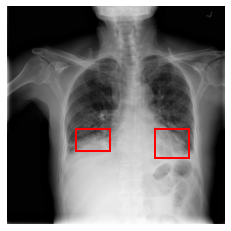

In [42]:
getPatientInfo('00704310-78a8-4b38-8475-49f4573b2dbb',True)

In [19]:
#Check if Dtype is a needed
PatientInfoDfTemp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              30227 non-null  object 
 1   Modality        30227 non-null  object 
 2   Sex             30227 non-null  object 
 3   Age             30227 non-null  object 
 4   BodyPart        30227 non-null  object 
 5   View            30227 non-null  object 
 6   X_coordinate    9555 non-null   float64
 7   Y_coordinate    9555 non-null   float64
 8   width           9555 non-null   float64
 9   height          9555 non-null   float64
 10  PneumoniaClass  30227 non-null  object 
 11  Target          30227 non-null  object 
 12  dcmPath         30227 non-null  object 
dtypes: float64(4), object(9)
memory usage: 3.0+ MB


In [20]:
#As Dtype of Age is set to Object, changing it to Int to help with BoxPlot
PatientInfoDfTemp['Age'] = pd.to_numeric(PatientInfoDfTemp['Age'])
PatientInfoDfTemp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              30227 non-null  object 
 1   Modality        30227 non-null  object 
 2   Sex             30227 non-null  object 
 3   Age             30227 non-null  int64  
 4   BodyPart        30227 non-null  object 
 5   View            30227 non-null  object 
 6   X_coordinate    9555 non-null   float64
 7   Y_coordinate    9555 non-null   float64
 8   width           9555 non-null   float64
 9   height          9555 non-null   float64
 10  PneumoniaClass  30227 non-null  object 
 11  Target          30227 non-null  object 
 12  dcmPath         30227 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usage: 3.0+ MB


In [147]:
print(tabulate([['Total Number of Enteries', PatientInfoDfTemp.ID.count()],\
                ['Total Number of Patients', PatientInfoDfTemp.ID.nunique()]],\
                headers=['Header', 'Value'], tablefmt='orgtbl'))

| Header                   |   Value |
|--------------------------+---------|
| Total Number of Enteries |   30227 |
| Total Number of Patients |   26684 |


Modality (medical imaging), a type of equipment used to acquire structural or functional images of the body, such as radiography, ultrasound, nuclear medicine, computed tomography, magnetic resonance imaging and visible light.

In [24]:
print('Different types of Modality in DataSet',PatientInfoDfTemp.Modality.unique())

Different types of Modality in DataSet ['CR']


| Header                                                            |   Value |
|-------------------------------------------------------------------+---------|
| Number of Male Patients                                           |   17216 |
| ----- Male Patients with Pneumonia                                |    5560 |
| ---------- Male Patients in Lung Opacities Class                  |    5560 |
| ----- Male Patients without Pneumonia                             |   11656 |
| ---------- Male Patients in Normal  Class                         |    4946 |
| ---------- Male Patients in No Lung Opacity / Not Normal  Class   |    6710 |
| Number of Female Patients                                         |   13011 |
| ----- Female Patients with Pneumonia                              |    3995 |
| ---------- Female Patients in Lung Opacities Class                |    3995 |
| ----- Female Patients without Pneumonia                           |    9016 |
| ---------- Female Patients in Normal  

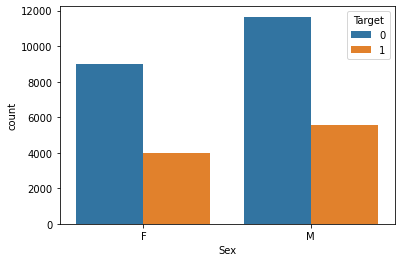

In [84]:
#Checking for the division of pneumonia patients with respect to their sex
print(tabulate([['Number of Male Patients', PatientInfoDfTemp.Sex[PatientInfoDfTemp['Sex'] == 'M'].count()],\
                ['----- Male Patients with Pneumonia', PatientInfoDfTemp.ID[(PatientInfoDfTemp['Sex'] == 'M') & (PatientInfoDfTemp['Target'] == 1)].count()],\
                ['---------- Male Patients in Lung Opacities Class', PatientInfoDfTemp.ID[(PatientInfoDfTemp['Sex'] == 'M') & (PatientInfoDfTemp['PneumoniaClass'] == 'Lung Opacity')].count()],\
                ['----- Male Patients without Pneumonia', PatientInfoDfTemp.ID[(PatientInfoDfTemp['Sex'] == 'M') & (PatientInfoDfTemp['Target'] == 0)].count()],\
                ['---------- Male Patients in Normal  Class', PatientInfoDfTemp.ID[(PatientInfoDfTemp['Sex'] == 'M') & (PatientInfoDfTemp['PneumoniaClass'] == 'Normal')].count()],\
                ['---------- Male Patients in No Lung Opacity / Not Normal  Class', PatientInfoDfTemp.ID[(PatientInfoDfTemp['Sex'] == 'M') & (PatientInfoDfTemp['PneumoniaClass'] == 'No Lung Opacity / Not Normal')].count()],\
                ['Number of Female Patients', PatientInfoDfTemp.Sex[PatientInfoDfTemp['Sex'] == 'F'].count()],\
                ['----- Female Patients with Pneumonia', PatientInfoDfTemp.ID[(PatientInfoDfTemp['Sex'] == 'F') & (PatientInfoDfTemp['Target'] == 1)].count()],\
                ['---------- Female Patients in Lung Opacities Class', PatientInfoDfTemp.ID[(PatientInfoDfTemp['Sex'] == 'F') & (PatientInfoDfTemp['PneumoniaClass'] == 'Lung Opacity')].count()],\
                ['----- Female Patients without Pneumonia', PatientInfoDfTemp.ID[(PatientInfoDfTemp['Sex'] == 'F') & (PatientInfoDfTemp['Target'] == 0)].count()],\
                ['---------- Female Patients in Normal  Class', PatientInfoDfTemp.ID[(PatientInfoDfTemp['Sex'] == 'F') & (PatientInfoDfTemp['PneumoniaClass'] == 'Normal')].count()],\
                ['---------- Female Patients in No Lung Opacity / Not Normal  Class', PatientInfoDfTemp.ID[(PatientInfoDfTemp['Sex'] == 'F') & (PatientInfoDfTemp['PneumoniaClass'] == 'No Lung Opacity / Not Normal')].count()]],\
                headers=['Header', 'Value'], tablefmt='orgtbl'))
print('----------------------------------------------------------')
sns.countplot(x='Sex',hue='Target',data=PatientInfoDfTemp)

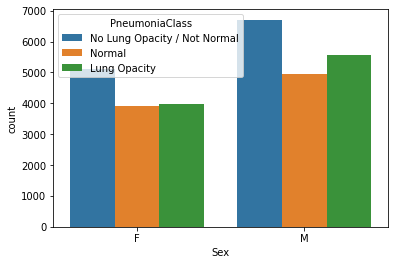

In [85]:
#Checking for the detailed class of pneumonia patients with respect to their sex
sns.countplot(x='Sex',hue='PneumoniaClass',data=PatientInfoDfTemp)

### Opacity is a pretty loose term - "Opacity refers to any area that preferentially attenuates the x-ray beam and therefore appears more opaque than the surrounding area. It is a nonspecific term that does not indicate the size or pathologic nature of the abnormality" 
---
Difference between Lung Opacities, Normal and No Lung 
Opacity / Not Normal
---
1. Lung Opacities : Target in stage_2_train_labels.csv is 1 and lungs X-Ray has Opacities [Refer to Image bellow]
2. Normal : Target in stage_2_train_labels.csv is 0 and lungs X-Ray has No Opacities [Refer to Image bellow]
3. No Lung Opacity / Not Normal : Target in stage_2_train_labels.csv is 1 and lungs X-Ray has opacities [Refer to Image bellow]

1. Lung Opacities
----------------------------------------------------------
| Header          | Value                                |
|-----------------+--------------------------------------|
| Patient ID      | 00704310-78a8-4b38-8475-49f4573b2dbb |
| Medical imaging | CR                                   |
| Sex             | M                                    |
| Age             | 75                                   |
| BodyPart        | CHEST                                |
| View            | PA                                   |
| Has Pneumonia?  | Yes                                  |
----------------------------------------------------------


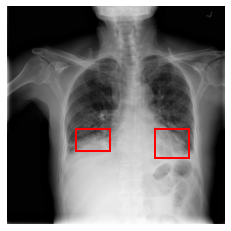

In [43]:
print('1. Lung Opacities')
print('----------------------------------------------------------')
getPatientInfo('00704310-78a8-4b38-8475-49f4573b2dbb',True)

2. Normal
----------------------------------------------------------
| Header          | Value                                |
|-----------------+--------------------------------------|
| Patient ID      | 003d8fa0-6bf1-40ed-b54c-ac657f8495c5 |
| Medical imaging | CR                                   |
| Sex             | M                                    |
| Age             | 28                                   |
| BodyPart        | CHEST                                |
| View            | PA                                   |
| Has Pneumonia?  | No                                   |
----------------------------------------------------------


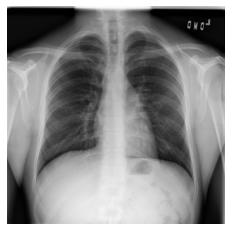

In [44]:
print('2. Normal')
print('----------------------------------------------------------')
getPatientInfo('003d8fa0-6bf1-40ed-b54c-ac657f8495c5',True)

3. No Lung Opacity / Not Normal
----------------------------------------------------------
| Header          | Value                                |
|-----------------+--------------------------------------|
| Patient ID      | 00322d4d-1c29-4943-afc9-b6754be640eb |
| Medical imaging | CR                                   |
| Sex             | M                                    |
| Age             | 19                                   |
| BodyPart        | CHEST                                |
| View            | AP                                   |
| Has Pneumonia?  | No                                   |
----------------------------------------------------------


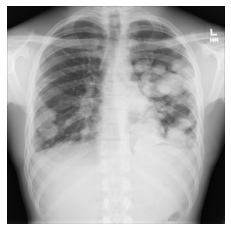

In [45]:
print('3. No Lung Opacity / Not Normal')
print('----------------------------------------------------------')
getPatientInfo('00322d4d-1c29-4943-afc9-b6754be640eb',True)

There are different kinds of opacities (see a general explanation about opacities above). Some are related to pneumonia and some are not. What we see in the image of Patient 3 are Lung Nodules and Masses, which are defined as "a rounded opacity, well or poorly defined" - Felson's Principles of Chest Roentgenology (Fourth Edition)

Missing Values : 0
Number of Outliers : 5


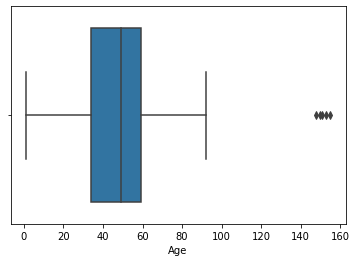

In [125]:
# Checking for Outliers in Age, and removing them
AgeData = PatientInfoDfTemp['Age']
q1=AgeData.quantile(0.25)
q3=AgeData.quantile(0.75)
print('Missing Values :',AgeData.isnull().sum())
IQR=q3-q1
NumOut=((AgeData.iloc[:] <(q1-1.5*IQR))|(AgeData.iloc[:]>(q3+1.5*IQR))).sum(axis=0)
PatientInfoClean = PatientInfoDfTemp[~((AgeData.iloc[:] <(q1-1.5*IQR))|(AgeData.iloc[:]>(q3+1.5*IQR)))]
print('Number of Outliers :',NumOut)
sns.boxplot(AgeData)

Missing Values : 0
Number of Outliers : 0


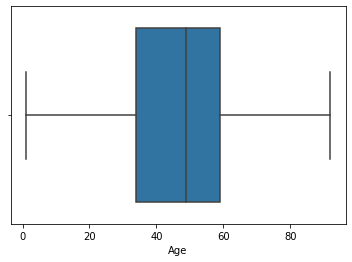

In [126]:
# Check if outliers are removed
AgeData = PatientInfoClean['Age']
q1=AgeData.quantile(0.25)
q3=AgeData.quantile(0.75)
IQR=q3-q1
NumOut=((AgeData.iloc[:] <(q1-1.5*IQR))|(AgeData.iloc[:]>(q3+1.5*IQR))).sum(axis=0)
print('Number of Outliers :',NumOut)
sns.boxplot(AgeData)

In [128]:
print('X-Ray of',PatientInfoDfTemp.BodyPart.unique(),'are available')

X-Ray of ['CHEST'] are available


Following X-Ray views are available ['PA' 'AP']
----------------------------------------------------------


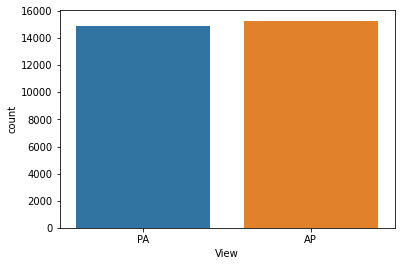

In [130]:
print('Following X-Ray views are available',PatientInfoDfTemp.View.unique())
print('----------------------------------------------------------')
sns.countplot(x='View',data=PatientInfoDfTemp)

1. PA : 
      *   the posteroanterior (PA) view is the standard frontal chest projection
      *   the x-ray beam traverses the patient from posterior to anterior
      *   it is performed standing and in full inspiration with the patient hugging the detector to pull the scapulae laterally
2. AP : 
      *   the anteroposterior (AP) erect view is an alternative frontal projection to the PA projection with the beam traversing the patient from anterior to posterior
      *   it can be performed with the patient sitting up on the bed and even performed outside the radiology department using a mobile x-ray unit

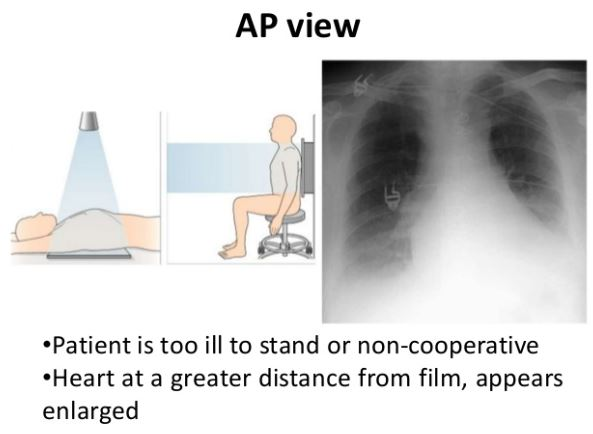

In [143]:
Image('/content/drive/My Drive/Colab Notebooks/Capstone/Images/AP.JPG')

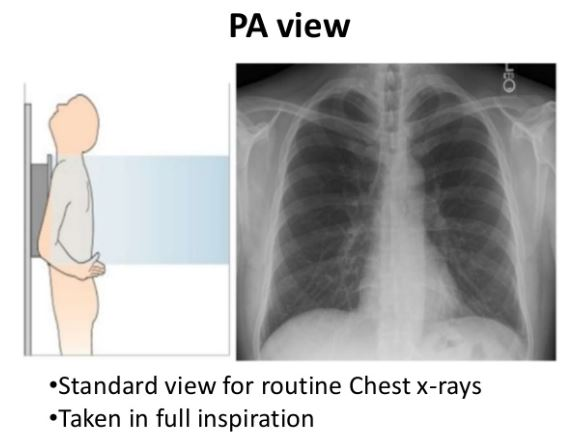

In [144]:
Image('/content/drive/My Drive/Colab Notebooks/Capstone/Images/PA.JPG')